In [1]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax, Softmax
from torch import flatten

In [2]:
import matplotlib

from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time
import line_profiler
import memory_profiler

In [3]:
BATCH_SIZE = 1
EPOCHS = 3

TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
trainDataK = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
 
print(int(len(trainDataK)))
print(int(len(testData)))

numTrainSamples = int(len(trainDataK) * TRAIN_SPLIT)
numValSamples = int(len(trainDataK) * VAL_SPLIT)
(trainData, valData, rest) = random_split(trainDataK,
	[1000, numValSamples, (int(len(trainDataK))-1000-numValSamples)],
	generator=torch.Generator().manual_seed(42))

60000
10000


In [5]:
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [6]:
class PyTorchNet(Module):
  def __init__(self, numChannels, classes):
    super(PyTorchNet, self).__init__()

    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.fc1 = Linear(in_features=800, out_features=500)

    self.fc2 = Linear(in_features=500, out_features=classes)
    self.softmax = Softmax(dim=1)


  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = flatten(x, 1)
    x = self.fc1(x)

    x = self.fc2(x)
    output = self.softmax(x)

    return output

In [7]:
model = PyTorchNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)

In [9]:
from torchsummary import summary

summary(model, (1,28,28))

ModuleNotFoundError: No module named 'torchsummary'

In [12]:
# from torch.profiler import profile, record_function, ProfilerActivity
# from memory_profiler import memory_usage
# from memory_profiler import profile
# import tracemalloc

#opt = Adam(model.parameters())
lossFn = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

# def trace_handler(p):
#     output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
#     print(output)
#     p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#     schedule=torch.profiler.schedule(
#         wait=2,
#         warmup=2,
#         active=6,
#         repeat=1),
#         profile_memory=True,
#     on_trace_ready=trace_handler,
#     with_stack=True
# ) as profiler:

def train_cnn(opt, model, trainDataLoader):
    for e in range(0, EPOCHS):
      model.train()
      totalTrainLoss = 0
      totalValLoss = 0
      trainCorrect = 0
      valCorrect = 0

      for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

      # with torch.no_grad():
      #   model.eval()

      #   for (x, y) in valDataLoader:
      #   	(x, y) = (x.to(device), y.to(device))

      #   	pred = model(x)
      #   	totalValLoss += lossFn(pred, y)

      #   	valCorrect += (pred.argmax(1) == y).type(
      #   		torch.float).sum().item()
      #profiler.step()
      avgTrainLoss = totalTrainLoss / trainSteps
      avgValLoss = totalValLoss / valSteps

      trainCorrect = trainCorrect / len(trainDataLoader.dataset)
      valCorrect = valCorrect / len(valDataLoader.dataset)

      # H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
      # H["train_acc"].append(trainCorrect)
      # H["val_loss"].append(avgValLoss.cpu().detach().numpy())
      # H["val_acc"].append(valCorrect)

#       print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
#       print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
#         avgTrainLoss, trainCorrect))
      # print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      #   avgValLoss, valCorrect))
 
#tracemalloc.start(400)
for i in range(100, 1000, 100):
  (trainData, rest) = random_split(trainDataK,
  [i, (int(len(trainDataK))-i)],
  generator=torch.Generator().manual_seed(42))
  trainDataLoader = DataLoader(trainData, shuffle=True,
  batch_size=BATCH_SIZE)
  model = PyTorchNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
  opt = Adam(model.parameters())

  print("Data size: ", i)
  
  #mem_bef, a = tracemalloc.get_traced_memory()
  #snapshot1 = tracemalloc.take_snapshot()
  time_sum = 0
  for i in range(1,4):
      startTime = time.time()
      train_cnn(opt, model, trainDataLoader)
      endTime = time.time()
      time_sum += (endTime - startTime)
  #mem_aft, a = tracemalloc.get_traced_memory()
  #snapshot2 = tracemalloc.take_snapshot()
  #top_stats = snapshot2.compare_to(snapshot1, "lineno")
#   sum = 0
#   for stat in top_stats:
#     sum += stat.size
#     #print(stat.traceback.format())
#   print(sum)
  print(i, " ", time_sum/3)


#   mem_usage = memory_usage((train_cnn, (opt, model, trainDataLoader)))
#   print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
#   print('Maximum memory usage: %s' % max(mem_usage))


# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

# with torch.no_grad():
# 	model.eval()
# 	preds = []

# 	for (x, y) in testDataLoader:
# 		x = x.to(device)
# 		pred = model(x)
# 		preds.extend(pred.argmax(axis=1).cpu().numpy())

# print(classification_report(testData.targets.cpu().numpy(),
# 	np.array(preds), target_names=testData.classes))


# plt.style.use("ggplot")
# plt.figure()
# plt.plot(H["train_loss"], label="train_loss")
# plt.plot(H["val_loss"], label="val_loss")
# plt.plot(H["train_acc"], label="train_acc")
# plt.plot(H["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("plot.png")

# torch.save(model, "model.pth")

Data size:  100
3   2.03564715385437
Data size:  200
3   4.867745320002238
Data size:  300
3   8.103740453720093
Data size:  400
3   10.14463472366333
Data size:  500
3   9.547699371973673
Data size:  600
3   18.702093760172527
Data size:  700


KeyboardInterrupt: 

In [25]:
from torch.profiler import profile, record_function, ProfilerActivity
from memory_profiler import memory_usage
from memory_profiler import profile
import tracemalloc

#opt = Adam(model.parameters())
lossFn = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

startTime = time.time()

# def trace_handler(p):
#     output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
#     print(output)
#     p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#     schedule=torch.profiler.schedule(
#         wait=2,
#         warmup=2,
#         active=6,
#         repeat=1),
#         profile_memory=True,
#     on_trace_ready=trace_handler,
#     with_stack=True
# ) as profiler:

def train_cnn(opt, model, trainDataLoader):
    for e in range(0, EPOCHS):
      model.train()
      totalTrainLoss = 0
      totalValLoss = 0
      trainCorrect = 0
      valCorrect = 0

      for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

      # with torch.no_grad():
      #   model.eval()

      #   for (x, y) in valDataLoader:
      #   	(x, y) = (x.to(device), y.to(device))

      #   	pred = model(x)
      #   	totalValLoss += lossFn(pred, y)

      #   	valCorrect += (pred.argmax(1) == y).type(
      #   		torch.float).sum().item()
      #profiler.step()
      avgTrainLoss = totalTrainLoss / trainSteps
      avgValLoss = totalValLoss / valSteps

      trainCorrect = trainCorrect / len(trainDataLoader.dataset)
      valCorrect = valCorrect / len(valDataLoader.dataset)

      # H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
      # H["train_acc"].append(trainCorrect)
      # H["val_loss"].append(avgValLoss.cpu().detach().numpy())
      # H["val_acc"].append(valCorrect)

#       print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
#       print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
#         avgTrainLoss, trainCorrect))
      # print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      #   avgValLoss, valCorrect))
 
#tracemalloc.start()
for i in range(100, 2000, 100):
  (trainData, rest) = random_split(trainDataK,
  [i, (int(len(trainDataK))-i)],
  generator=torch.Generator().manual_seed(42))
  trainDataLoader = DataLoader(trainData, shuffle=True,
  batch_size=BATCH_SIZE)
  model = PyTorchNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
  opt = Adam(model.parameters())

  print("Data size: ", i)
  %timeit train_cnn(opt, model, trainDataLoader)
  #%memit train_cnn(opt, model, trainDataLoader)

#   mem_usage = memory_usage((train_cnn, (opt, model, trainDataLoader)))
#   print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
#   print('Maximum memory usage: %s' % max(mem_usage))


# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

# with torch.no_grad():
# 	model.eval()
# 	preds = []

# 	for (x, y) in testDataLoader:
# 		x = x.to(device)
# 		pred = model(x)
# 		preds.extend(pred.argmax(axis=1).cpu().numpy())

# print(classification_report(testData.targets.cpu().numpy(),
# 	np.array(preds), target_names=testData.classes))


# plt.style.use("ggplot")
# plt.figure()
# plt.plot(H["train_loss"], label="train_loss")
# plt.plot(H["val_loss"], label="val_loss")
# plt.plot(H["train_acc"], label="train_acc")
# plt.plot(H["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("plot.png")

# torch.save(model, "model.pth")

Data size:  100
2.7 s ± 440 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  200
6.19 s ± 505 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  300
10.4 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  400
12.9 s ± 886 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  500
14.4 s ± 462 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  600
18.9 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  700
22.5 s ± 871 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  800
27.2 s ± 758 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  900
33 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  1000
26.7 s ± 380 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  1100
37.7 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data size:  1200
36.8 s ± 633 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Data

In [12]:
from torch.profiler import profile, record_function, ProfilerActivity
from memory_profiler import memory_usage
from memory_profiler import profile
import tracemalloc

#opt = Adam(model.parameters())
lossFn = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


# def trace_handler(p):
#     output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
#     print(output)
#     p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#     schedule=torch.profiler.schedule(
#         wait=2,
#         warmup=2,
#         active=6,
#         repeat=1),
#         profile_memory=True,
#     on_trace_ready=trace_handler,
#     with_stack=True
# ) as profiler:

def train_cnn(opt, model, trainDataLoader):
    for e in range(0, EPOCHS):
      model.train()
      totalTrainLoss = 0
      totalValLoss = 0
      trainCorrect = 0
      valCorrect = 0

      for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

      # with torch.no_grad():
      #   model.eval()

      #   for (x, y) in valDataLoader:
      #   	(x, y) = (x.to(device), y.to(device))

      #   	pred = model(x)
      #   	totalValLoss += lossFn(pred, y)

      #   	valCorrect += (pred.argmax(1) == y).type(
      #   		torch.float).sum().item()
      #profiler.step()
      avgTrainLoss = totalTrainLoss / trainSteps
      avgValLoss = totalValLoss / valSteps

      trainCorrect = trainCorrect / len(trainDataLoader.dataset)
      valCorrect = valCorrect / len(valDataLoader.dataset)

      # H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
      # H["train_acc"].append(trainCorrect)
      # H["val_loss"].append(avgValLoss.cpu().detach().numpy())
      # H["val_acc"].append(valCorrect)

#       print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
#       print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
#         avgTrainLoss, trainCorrect))
      # print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      #   avgValLoss, valCorrect))
 
#tracemalloc.start()
for i in range(200, 2000, 100):
  (trainData, rest) = random_split(trainDataK,
  [i, (int(len(trainDataK))-i)],
  generator=torch.Generator().manual_seed(42))
  trainDataLoader = DataLoader(trainData, shuffle=True,
  batch_size=BATCH_SIZE)
  model = PyTorchNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
  opt = Adam(model.parameters())

  print("Data size: ", i)
  %timeit -r 2 train_cnn(opt, model, trainDataLoader) 
  #%memit train_cnn(opt, model, trainDataLoader)

#   mem_usage = memory_usage((train_cnn, (opt, model, trainDataLoader)))
#   print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
#   print('Maximum memory usage: %s' % max(mem_usage))


# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

# with torch.no_grad():
# 	model.eval()
# 	preds = []

# 	for (x, y) in testDataLoader:
# 		x = x.to(device)
# 		pred = model(x)
# 		preds.extend(pred.argmax(axis=1).cpu().numpy())

# print(classification_report(testData.targets.cpu().numpy(),
# 	np.array(preds), target_names=testData.classes))


# plt.style.use("ggplot")
# plt.figure()
# plt.plot(H["train_loss"], label="train_loss")
# plt.plot(H["val_loss"], label="val_loss")
# plt.plot(H["train_acc"], label="train_acc")
# plt.plot(H["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("plot.png")

# torch.save(model, "model.pth")

Data size:  200
6.98 s ± 378 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  300
8.87 s ± 181 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  400
12.8 s ± 106 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  500
16.6 s ± 505 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  600
22.1 s ± 178 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  700
18.6 s ± 145 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  800
28.1 s ± 283 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  900
31.6 s ± 2.44 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  1000
37.4 s ± 542 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  1100
36.5 s ± 428 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  1200
35.4 s ± 4.02 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  1300


KeyboardInterrupt: 

In [13]:
from torch.profiler import profile, record_function, ProfilerActivity
from memory_profiler import memory_usage
from memory_profiler import profile
import tracemalloc

#opt = Adam(model.parameters())
lossFn = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


# def trace_handler(p):
#     output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
#     print(output)
#     p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#     schedule=torch.profiler.schedule(
#         wait=2,
#         warmup=2,
#         active=6,
#         repeat=1),
#         profile_memory=True,
#     on_trace_ready=trace_handler,
#     with_stack=True
# ) as profiler:

def train_cnn(opt, model, trainDataLoader):
    for e in range(0, EPOCHS):
      model.train()
      totalTrainLoss = 0
      totalValLoss = 0
      trainCorrect = 0
      valCorrect = 0

      for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

      # with torch.no_grad():
      #   model.eval()

      #   for (x, y) in valDataLoader:
      #   	(x, y) = (x.to(device), y.to(device))

      #   	pred = model(x)
      #   	totalValLoss += lossFn(pred, y)

      #   	valCorrect += (pred.argmax(1) == y).type(
      #   		torch.float).sum().item()
      #profiler.step()
      avgTrainLoss = totalTrainLoss / trainSteps
      avgValLoss = totalValLoss / valSteps

      trainCorrect = trainCorrect / len(trainDataLoader.dataset)
      valCorrect = valCorrect / len(valDataLoader.dataset)

      # H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
      # H["train_acc"].append(trainCorrect)
      # H["val_loss"].append(avgValLoss.cpu().detach().numpy())
      # H["val_acc"].append(valCorrect)

#       print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
#       print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
#         avgTrainLoss, trainCorrect))
      # print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      #   avgValLoss, valCorrect))
 
#tracemalloc.start()
for i in range(2000, 11000, 1000):
  (trainData, rest) = random_split(trainDataK,
  [i, (int(len(trainDataK))-i)],
  generator=torch.Generator().manual_seed(42))
  trainDataLoader = DataLoader(trainData, shuffle=True,
  batch_size=BATCH_SIZE)
  model = PyTorchNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
  opt = Adam(model.parameters())

  print("Data size: ", i)
  %timeit -r 2 train_cnn(opt, model, trainDataLoader) 
  #%memit train_cnn(opt, model, trainDataLoader)

#   mem_usage = memory_usage((train_cnn, (opt, model, trainDataLoader)))
#   print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
#   print('Maximum memory usage: %s' % max(mem_usage))


# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

# with torch.no_grad():
# 	model.eval()
# 	preds = []

# 	for (x, y) in testDataLoader:
# 		x = x.to(device)
# 		pred = model(x)
# 		preds.extend(pred.argmax(axis=1).cpu().numpy())

# print(classification_report(testData.targets.cpu().numpy(),
# 	np.array(preds), target_names=testData.classes))


# plt.style.use("ggplot")
# plt.figure()
# plt.plot(H["train_loss"], label="train_loss")
# plt.plot(H["val_loss"], label="val_loss")
# plt.plot(H["train_acc"], label="train_acc")
# plt.plot(H["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("plot.png")

# torch.save(model, "model.pth")

Data size:  2000
51.1 s ± 159 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  3000
1min 38s ± 3.68 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  4000
2min 25s ± 2.65 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  5000
2min 40s ± 1.98 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  6000
4min 4s ± 1.75 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  7000
4min 32s ± 6.79 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  8000
5min 5s ± 13.2 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  9000
5min 53s ± 32.3 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
Data size:  10000
6min 47s ± 45.2 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [11]:
%load_ext line_profiler
%load_ext memory_profiler

[INFO] EPOCH: 1/10
Train loss: 1.669889, Train accuracy: 0.8658
Val loss: 1.811708, Val accuracy: 0.8777

[INFO] EPOCH: 2/10
Train loss: 1.643822, Train accuracy: 0.8912
Val loss: 1.800489, Val accuracy: 0.8875

[INFO] EPOCH: 3/10
Train loss: 1.636721, Train accuracy: 0.8978
Val loss: 1.796199, Val accuracy: 0.8919

[INFO] EPOCH: 4/10
Train loss: 1.631951, Train accuracy: 0.9023
Val loss: 1.791705, Val accuracy: 0.8956

[INFO] EPOCH: 5/10
Train loss: 1.628658, Train accuracy: 0.9053
Val loss: 1.789718, Val accuracy: 0.8987

[INFO] EPOCH: 6/10
Train loss: 1.626401, Train accuracy: 0.9075
Val loss: 1.787990, Val accuracy: 0.8995

[INFO] EPOCH: 7/10
Train loss: 1.624618, Train accuracy: 0.9094
Val loss: 1.788271, Val accuracy: 0.8980

[INFO] EPOCH: 8/10
Train loss: 1.621840, Train accuracy: 0.9116
Val loss: 1.783238, Val accuracy: 0.9033

[INFO] EPOCH: 9/10
Train loss: 1.619372, Train accuracy: 0.9137
Val loss: 1.783312, Val accuracy: 0.9024

[INFO] EPOCH: 10/10
Train loss: 1.617666, Trai

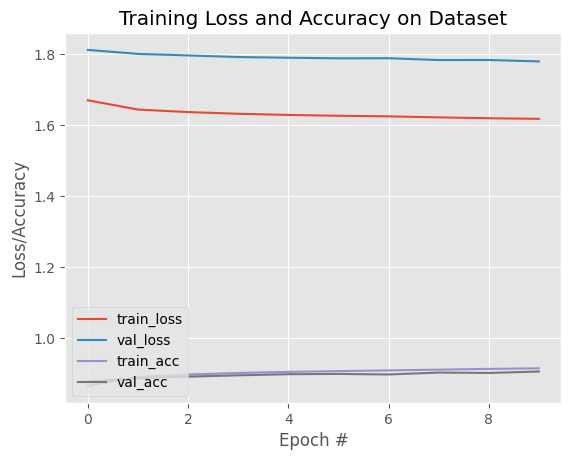

In [ ]:
opt = Adam(model.parameters())
lossFn = nn.CrossEntropyLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

startTime = time.time()

for e in range(0, EPOCHS):
	model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	trainCorrect = 0
	valCorrect = 0

	for (x, y) in trainDataLoader:
		(x, y) = (x.to(device), y.to(device))
		pred = model(x)
		loss = lossFn(pred, y)
		opt.zero_grad()
		loss.backward()
		opt.step()
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	with torch.no_grad():
		model.eval()

		# for (x, y) in valDataLoader:
		# 	(x, y) = (x.to(device), y.to(device))

		# 	pred = model(x)
		# 	totalValLoss += lossFn(pred, y)

		# 	valCorrect += (pred.argmax(1) == y).type(
		# 		torch.float).sum().item()

	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)

	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))
 


endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

with torch.no_grad():
	model.eval()
	preds = []

	for (x, y) in testDataLoader:
		x = x.to(device)
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))


plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

torch.save(model, "model.pth")

In [ ]:
import numpy as np
np.random.seed(42)

from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import argparse
import imutils
import torch
import cv2
from matplotlib import pyplot as plt

[INFO] ground truth label: na, predicted label: na


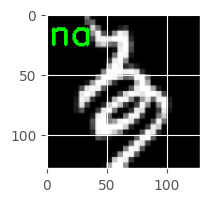

[INFO] ground truth label: tsu, predicted label: tsu


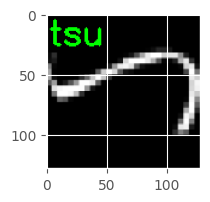

[INFO] ground truth label: tsu, predicted label: tsu


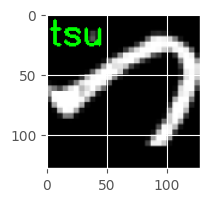

[INFO] ground truth label: su, predicted label: su


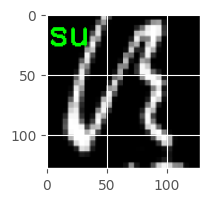

[INFO] ground truth label: o, predicted label: o


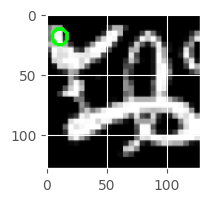

[INFO] ground truth label: ma, predicted label: ma


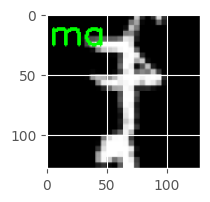

[INFO] ground truth label: su, predicted label: su


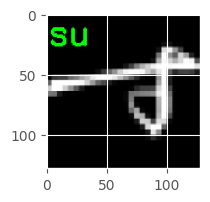

[INFO] ground truth label: o, predicted label: o


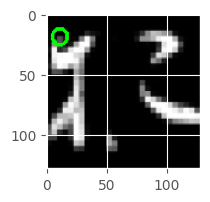

[INFO] ground truth label: na, predicted label: o


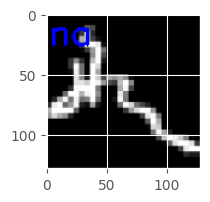

[INFO] ground truth label: ki, predicted label: ki


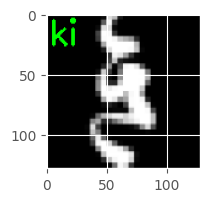

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testDataSub = Subset(testData, idxs)

testDataLoader = DataLoader(testDataSub, batch_size=1)

model = torch.load("model.pth").to(device)
model.eval()
plt.rcParams['figure.figsize'] = (2,2)
with torch.no_grad():
	for (image, label) in testDataLoader:
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testDataSub.dataset.classes[label.numpy()[0]]
		image = image.to(device)
		pred = model(image)
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testDataSub.dataset.classes[idx]
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25),
			cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		print("[INFO] ground truth label: {}, predicted label: {}".format(
			gtLabel, predLabel))
		plt.imshow((origImage*255).astype(np.uint16))
		plt.show()


In [ ]:
testDataSub.dataset.classes

NameError: ignored